<a href="https://colab.research.google.com/github/chavgova/Brain/blob/main/2_obj_data/all_data/EEG_10_normalized_std.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import codecs
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import math
import numpy as np
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
from scipy import signal
import scipy.io as scio
import pandas as pd
from scipy.signal import hilbert
from tensorflow.keras.layers import Flatten
from sklearn.utils import shuffle

In [ ]:
dataset_folder_path = '/content/drive/MyDrive/Brain/EEG_data/Bands/'
model_path = '/content/drive/MyDrive/Brain/EEG_Models/'
model_name = 'EEG_10_model_3d_norm_STD'
channels_list = ['c3', 'c4', 'f3', 'f4', 'p3', 'p4']  # file names format 'c3_input_alpha.txt'
values_per_file = 39000
values_per_split = 9750
fs = 256 # Hz
# object_num = 4
channel_num = len(channels_list)

# Creating the DATASET

In [ ]:
dataset_files_list = [] 
dataset_files_list = os.listdir(dataset_folder_path)

print(dataset_files_list)
object_num = len(dataset_files_list)

['eeg_bands_object_1_fear', 'eeg_bands_object_2_joy', 'eeg_bands_object_1_joy', 'eeg_bands_object_2_fear']


In [ ]:
label_list = []

for item in dataset_files_list:
  if 'joy' in item:
    label_list.append('joy')
  elif 'fear' in item:
    label_list.append('fear')
print(label_list)    

['fear', 'joy', 'joy', 'fear']


# fs=256 Hz
Theta - 4 - 7.5 Hz

Alpha - 8 - 13.5 Hz

Beta -  14 - 30 Hz

Gamma - 30.5 - 40 Hz

In [ ]:
def formatDataFromTXT(contents):
  contents_list = contents.splitlines()
  contents_array = np.array([])

  contents_array = np.array([float(a) for a in contents_list])
  a = int((contents_array.shape[0]-values_per_file)/2)
  contents_array = contents_array[a:-a]  ##############
  
  return contents_array 

def ReadObjectData(object_folder_name):
  object_data_3d = np.empty((channel_num, 4, values_per_file), float)  # object = (channels, bands, values) = (6, 4, values)
  i = 0 # channel counter
  for channel_name in channels_list:
    channel_data_2d = ReadChannelData(channel_name)
    object_data_3d[i] = channel_data_2d
    i+=1

  return object_data_3d

def ReadChannelData(channel_name):
  channel_data_2d = np.empty((4, values_per_file), float) # channel = (bands, values)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_alpha.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  alpha_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_beta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  beta_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_gamma.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  gamma_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_theta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  theta_data = formatDataFromTXT(contents)
  channel_data_2d[0] = theta_data
  channel_data_2d[1] = alpha_data
  channel_data_2d[2] = beta_data
  channel_data_2d[3] = gamma_data

  return channel_data_2d

(objects, channels, bands, values) = (4, 6, 4, 40000)

In [ ]:
objects_data_4d = np.empty((object_num, channel_num, 4, values_per_file), float) # (objects, channels, bands, values) = (4, 6, 4, 40000)

j = 0 # object counter 

for object_folder_name in dataset_files_list:
  object_data_3d = ReadObjectData(object_folder_name)
  objects_data_4d[j] = object_data_3d
  j+=1

print(objects_data_4d)

[[[[  0.99851246   1.2463123    1.4635768  ...   2.403994
      2.3017453    2.1664624 ]
   [ -1.445182    -1.168948    -0.80276405 ...  -1.4480942
     -1.4844276   -1.43031   ]
   [ -0.47241475  -0.78637838  -0.85391767 ...   0.19982705
      0.70106691   0.93756382]
   [  0.30550873  -1.3409385   -2.1313223  ...   0.2272816
     -0.74526399  -1.3067048 ]]

  [[ -1.5718457   -1.5453251   -1.4949847  ...  -1.7543221
     -2.047008    -2.2707875 ]
   [  3.7922253    3.517771     3.0004753  ...  -4.6269751
     -3.7712863   -2.6967369 ]
   [ -2.156035    -1.5119296   -0.04733826 ...   3.364506
      3.6513618    3.4169416 ]
   [  3.435061     3.3809571    0.8890103  ...   2.0181921
      2.3892486    1.0286029 ]]

  [[ -0.50891707  -0.31027898  -0.10954685 ...   2.1283049
      2.0532411    1.9494225 ]
   [  1.5839479    2.1723225    2.6031686  ...  -8.1001747
     -8.3238203   -8.0164988 ]
   [  1.5323874    1.6039654    1.6474962  ...   0.31907498
      1.0598392    1.6268175 ]
   [  

In [ ]:
print(objects_data_4d.shape)
print(objects_data_4d[0, 0, 0, :]) # [0, 0, 0, :] == first object, c3 (first channel), theta band, values 

(4, 6, 4, 39000)
[0.99851246 1.2463123  1.4635768  ... 2.403994   2.3017453  2.1664624 ]


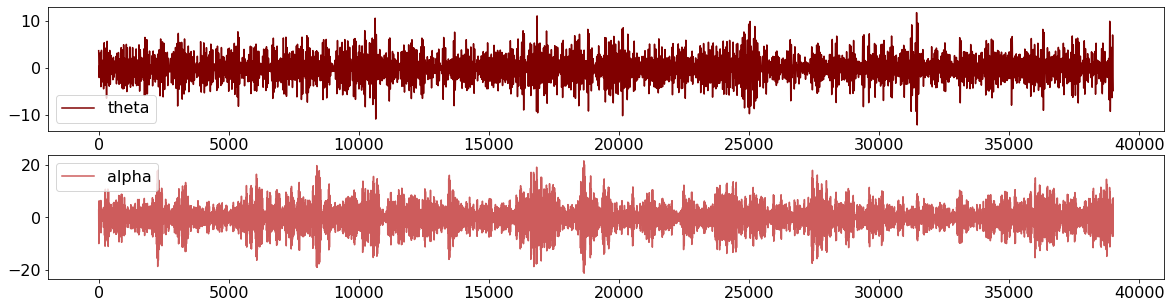

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d[2, 3, 0, :], label='theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d[2, 3, 1, :], label='alpha', color='indianred')
plt.legend()

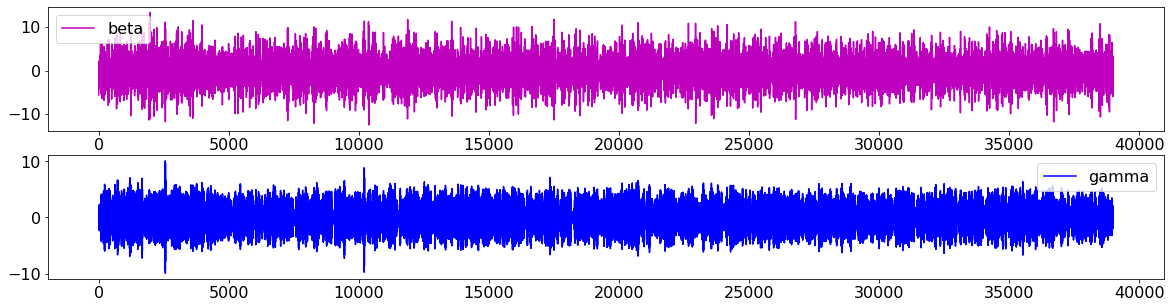

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d[2, 3, 2, :], label='beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d[2, 3, 3, :], label='gamma', color='b')
plt.legend()

(objects, channels, bands, values) = (4, 6, 4, 40000)

# **NORMALIZE**

In [ ]:
from sklearn import preprocessing

def StandardizeByChannel(data):
  objects_data_4d_scaled = np.empty((4, channel_num, 4, values_per_file), float)  # (objects, channels, bands, values) = (4, 6, 4, 40000)
  j = 0 # object counter
  i = 0 # channel counter
  for j in range(0,4):
    for i in range(0,6):
      objects_data_4d_scaled[j, i, :, :] = preprocessing.normalize(data[j, i, :, :])
      i+=1
    j+=1  

  return objects_data_4d_scaled

In [ ]:
objects_data_4d = StandardizeByChannel(objects_data_4d)

**SPLIT**

In [ ]:
objects_data_4d_split = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, values_per_split))
j = 0

for obj in range(0, object_num):
  i = 0

  while i < values_per_file:
      objects_data_4d_split[j] = objects_data_4d[obj,:,:,i:(i+values_per_split)]
      i+=values_per_split
      j+=1

print(objects_data_4d_split)      
print(objects_data_4d_split.shape) 

[[[[ 2.70569014e-03  3.37715856e-03  3.96588473e-03 ... -9.00540426e-04
    -1.67516833e-03 -2.48234597e-03]
   [-3.48502099e-03 -2.81888946e-03 -1.93584584e-03 ... -1.70647150e-03
    -1.50260483e-03 -1.22085175e-03]
   [-1.79909569e-03 -2.99476244e-03 -3.25197212e-03 ...  1.93142247e-03
    -1.19849198e-03 -2.34077361e-03]
   [ 1.31936999e-03 -5.79097696e-03 -9.20432841e-03 ... -8.04605140e-03
    -4.04605239e-03  2.92598095e-03]]

  [[-2.24535654e-03 -2.20747229e-03 -2.13556183e-03 ... -3.25520093e-03
    -3.62438149e-03 -3.92953769e-03]
   [ 4.88987489e-03  4.53598051e-03  3.86895494e-03 ... -4.71825305e-03
    -4.32013231e-03 -3.71518706e-03]
   [-4.18194363e-03 -2.93260748e-03 -9.18194498e-05 ...  2.16027205e-03
    -8.43298229e-04 -3.40643766e-03]
   [ 9.56425622e-03  9.41361448e-03  2.47527549e-03 ...  4.21088207e-03
    -1.61900979e-03 -6.15264164e-03]]

  [[-9.59411116e-04 -5.84938333e-04 -2.06517863e-04 ... -2.67948391e-03
    -3.55550678e-03 -4.42242602e-03]
   [ 2.03413799

'c3', 'c4', 'f3', 'f4', 'p3', 'p4'

 ...]

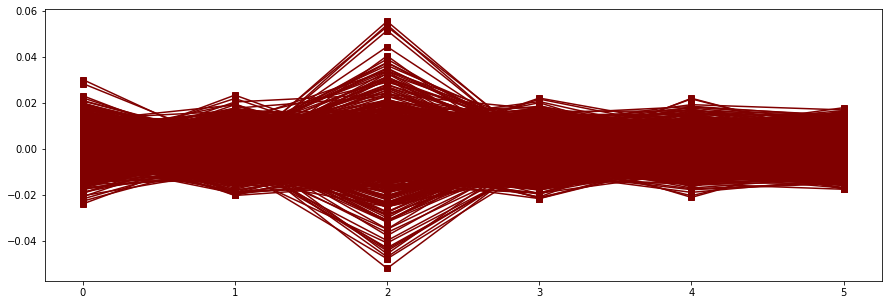

In [ ]:
b = np.array(objects_data_4d_split[0, :, 2, :]) 

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

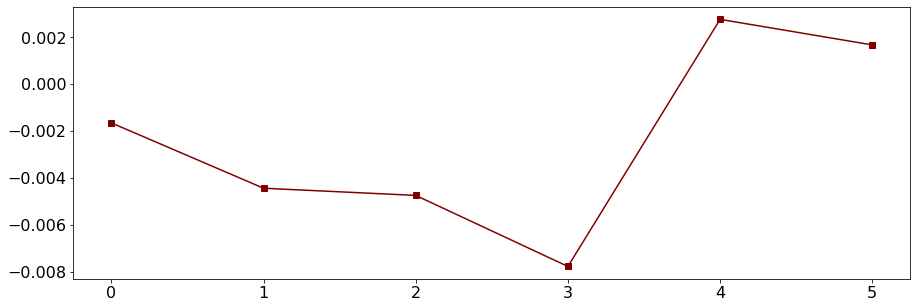

In [ ]:
b = np.array(objects_data_4d_split[1, :, 2, 0]) 
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

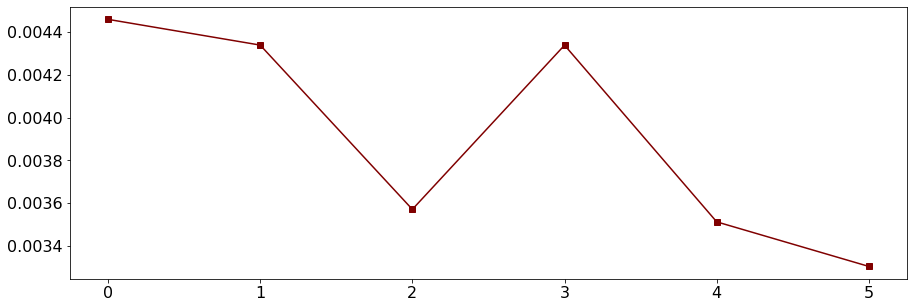

In [ ]:
b = np.array(objects_data_4d_split[5, :, 2, 0]) # joy

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

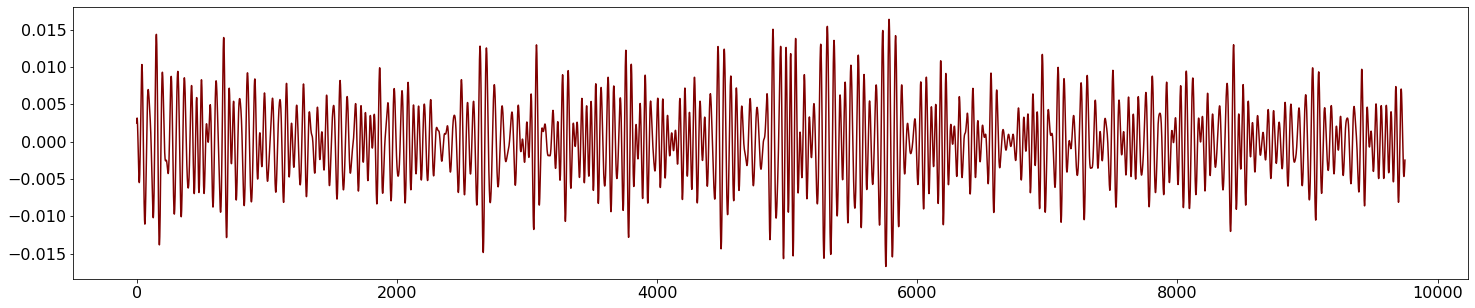

In [ ]:
b = np.array(objects_data_4d_split[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

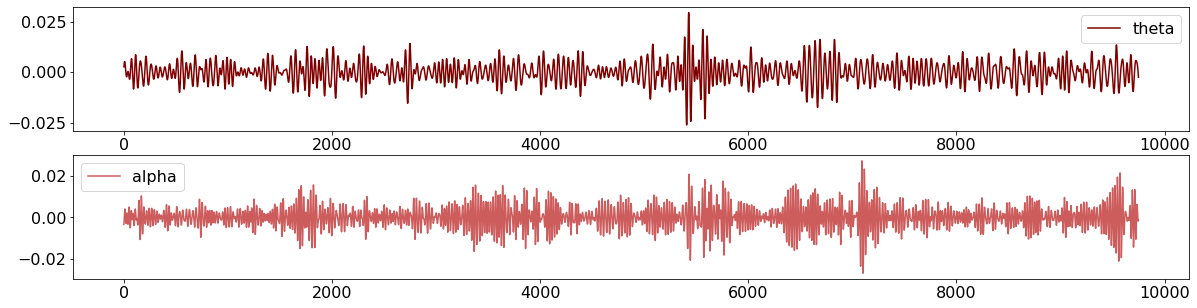

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 0, :], label='theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 1, :], label='alpha', color='indianred')
plt.legend()

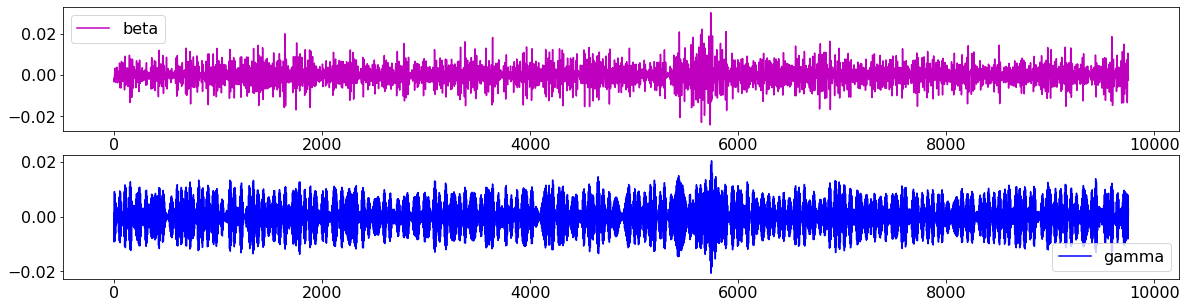

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 2, :], label='beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 3, :], label='gamma', color='b')
plt.legend()

In [ ]:
objects_data_4d_split[0,:,:,:].shape

(6, 4, 9750)

In [ ]:
np.var(objects_data_4d_split[2,:,:,:])

2.5740851186969267e-05

In [ ]:
label_list = [ item for item in label_list for repetitions in range(4) ]
label_list

['fear',
 'fear',
 'fear',
 'fear',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'fear',
 'fear',
 'fear',
 'fear']

In [ ]:
i=0
while i!=16:
  rat = np.ptp(objects_data_4d_split[i,:,:,:])/np.std(objects_data_4d_split[i,:,:,:])
  print(label_list[i], " -> ", rat)
  i+=1

fear  ->  21.369407791038146
fear  ->  10.575052681963463
fear  ->  14.266658566599244
fear  ->  37.201240247543964
joy  ->  9.628202983542797
joy  ->  9.022873448231229
joy  ->  8.033322914081202
joy  ->  9.216755153718239
joy  ->  10.635566113255317
joy  ->  10.234041884287157
joy  ->  14.311208281941013
joy  ->  18.90409446290843
fear  ->  9.823012151113359
fear  ->  10.11092050835114
fear  ->  11.500336612118936
fear  ->  7.947213023307328


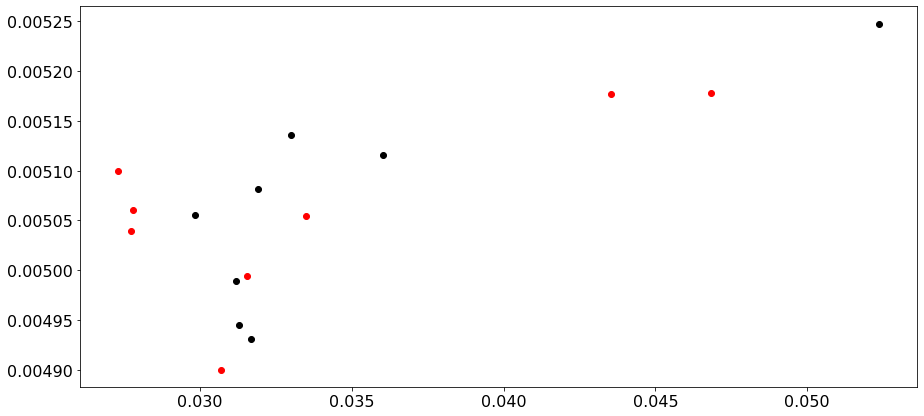

In [ ]:
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 16})

x = np.array( [ np.ptp(item) for item in objects_data_4d_split[:4,3,3,:]])
y = np.array( [ np.std(item) for item in objects_data_4d_split[:4,3,3,:]])
plt.plot(x, y, 'o', color='black')
x = np.array( [ np.ptp(item) for item in objects_data_4d_split[4:12,3,3,:]])
y = np.array( [ np.std(item) for item in objects_data_4d_split[4:12,3,3,:]])
plt.plot(x, y, 'o', color='red')
x = np.array( [ np.ptp(item) for item in objects_data_4d_split[12:,3,3,:]])
y = np.array( [ np.std(item) for item in objects_data_4d_split[12:,3,3,:]])
plt.plot(x, y, 'o', color='black')


In [ ]:
x

array([2.84387431e-05, 2.32285884e-05, 2.63995257e-05, 2.44970454e-05])

Shuffle

In [ ]:
objects_data_4d_split, label_list = shuffle(objects_data_4d_split, label_list)
print(label_list)

['fear', 'joy', 'fear', 'fear', 'joy', 'joy', 'joy', 'fear', 'fear', 'fear', 'joy', 'fear', 'joy', 'joy', 'joy', 'fear']


In [ ]:
label_list_0or1 = []
for label in label_list:
  if label == 'joy':
    label_list_0or1.append(0.)
  elif label == 'fear':
    label_list_0or1.append(1.)
    
label_list_0or1 = np.array(label_list_0or1)
print(label_list_0or1)  

[1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.]


1 average value per 1000 values 

In [ ]:
objects_data_4d_split_extract = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, 10))

for i in range(0, 16):
  for j in range(0, channel_num):
    for k in range(0, 4):
      for l in range(0,9):
        objects_data_4d_split_extract[i, j, k, l] = np.std(objects_data_4d_split[i, j, k, l*975:(l+1)*975])

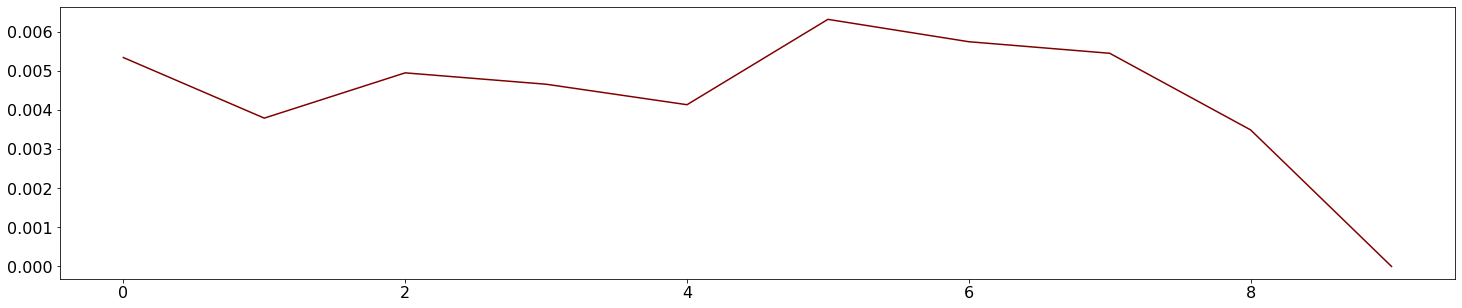

In [ ]:
b = np.array(objects_data_4d_split_extract[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

TRAIN / TEST 

In [ ]:
num_1 = 0
num_0 = 0
i = 0
index_list = []

while len(index_list)<4:
  if (label_list_0or1[i] == 0) and (num_0!=2):
    index_list.append(i)
    num_0+=1
  elif (label_list_0or1[i] == 1) and (num_1!=2): 
    index_list.append(i)
    num_1+=1
  i+=1
print(i)

5


In [ ]:
x_test = objects_data_4d_split_extract[index_list,:]
y_test = label_list_0or1[index_list]
print(y_test)

[1. 0. 1. 0.]


In [ ]:
x_test

array([[[[0.00423481, 0.00467683, 0.00504947, 0.00410122, 0.00437277,
          0.0080049 , 0.0062997 , 0.00484811, 0.00487469, 0.        ],
         [0.00315617, 0.00501537, 0.00378584, 0.00626454, 0.00506014,
          0.00661414, 0.00581182, 0.00672986, 0.00389353, 0.        ],
         [0.00409188, 0.00531873, 0.00403017, 0.00452884, 0.00513731,
          0.00654355, 0.00498588, 0.00467542, 0.00417235, 0.        ],
         [0.00525463, 0.00526542, 0.00467456, 0.00494728, 0.0051573 ,
          0.00634673, 0.00475595, 0.00497091, 0.00472717, 0.        ]],

        [[0.00304075, 0.00318295, 0.00366088, 0.00344963, 0.00405815,
          0.0041473 , 0.00369923, 0.00404164, 0.00287926, 0.        ],
         [0.00241016, 0.00517184, 0.0031626 , 0.00534499, 0.00498896,
          0.00549523, 0.00589817, 0.00658621, 0.00310346, 0.        ],
         [0.00361764, 0.00445197, 0.00479209, 0.00454418, 0.00552064,
          0.00595314, 0.00565021, 0.00486417, 0.00479914, 0.        ],
         [0

In [ ]:
x_train = np.delete(objects_data_4d_split_extract, index_list, 0)
y_train = np.delete(label_list_0or1, index_list)
print(x_train.shape)

(12, 6, 4, 10)


Reshape Data

In [ ]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1,1))

In [ ]:
y_train

array([[[1.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[0.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Dense(16, input_shape=(channel_num, 4, 10), activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6, 4, 16)          176       
                                                                 
 dense_1 (Dense)             (None, 6, 4, 8)           136       
                                                                 
 dense_2 (Dense)             (None, 6, 4, 4)           36        
                                                                 
 dense_3 (Dense)             (None, 6, 4, 1)           5         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


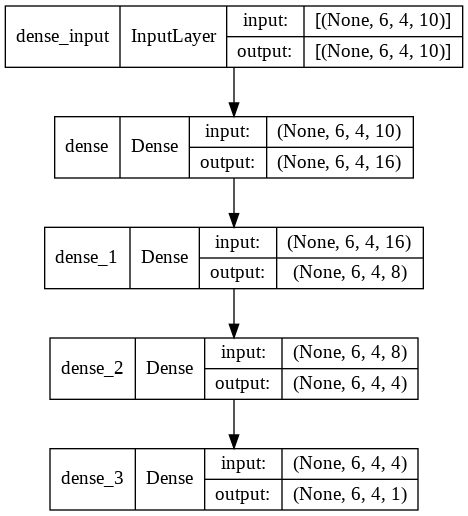

In [ ]:
plot_model(model, to_file=(model_path+'NNmodel_plot.png'), show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=4, validation_data = (x_test, y_test))

Epoch 1/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.6758 - accuracy: 0.5799 - val_loss: 0.6686 - val_accuracy: 0.6458
Epoch 2/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.6846 - accuracy: 0.5451 - val_loss: 0.6713 - val_accuracy: 0.5417
Epoch 3/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.6883 - accuracy: 0.5139 - val_loss: 0.6682 - val_accuracy: 0.7083
Epoch 4/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.6978 - accuracy: 0.3854 - val_loss: 0.6699 - val_accuracy: 0.5625
Epoch 5/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.6800 - accuracy: 0.6042 - val_loss: 0.6685 - val_accuracy: 0.6354
Epoch 6/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.6752 - accuracy: 0.6319 - val_loss: 0.6683 - val_accuracy: 0.6354
Epoch 7/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.6752 - accuracy: 0.6389 - val_loss: 0.6681 - val_accuracy: 0.6562
Epoch 8/1000


In [ ]:
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 20ms/step - loss: 0.6136 - accuracy: 0.7292
Accuracy: 72.92


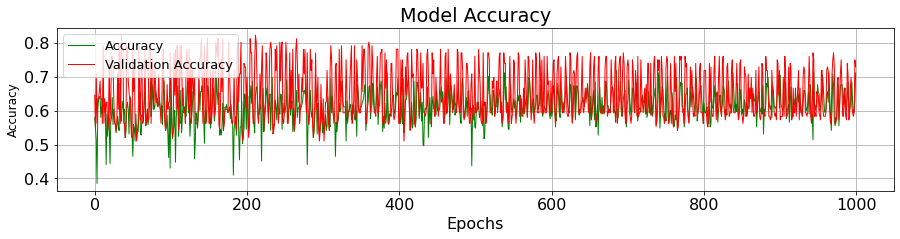

In [ ]:
plt.figure(figsize=(15,3), frameon=True)
plt.rcParams.update({'font.size': 16})

plt.plot(history.history['accuracy'], 'g', linewidth=1)
plt.plot(history.history['val_accuracy'], 'r', linewidth=1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)
plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

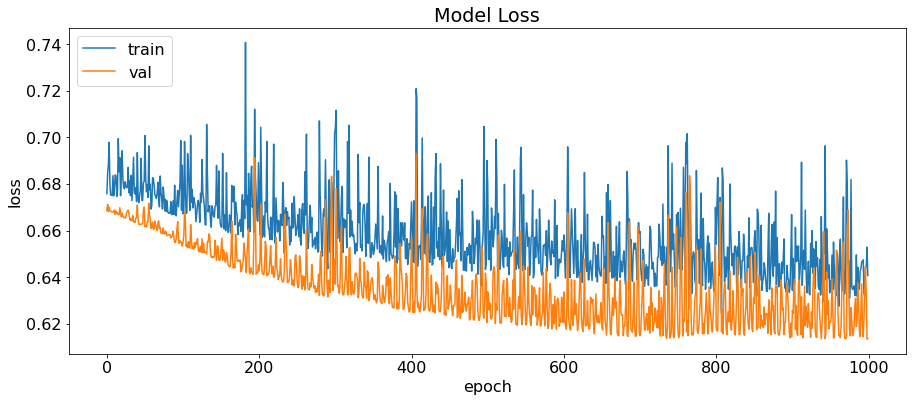

In [ ]:
plt.figure(figsize=(15,6), frameon=True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Figure size 1080x360 with 0 Axes>

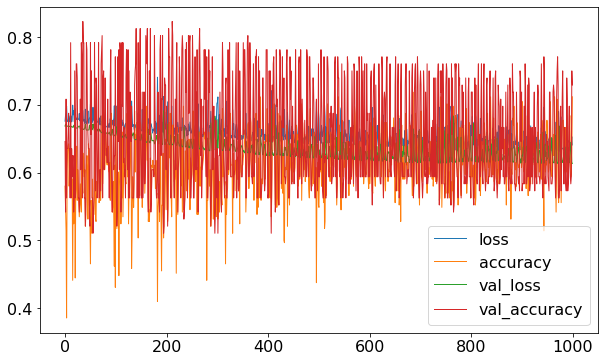

In [ ]:
plt.figure(figsize=(15,5), frameon=True)
pd.DataFrame(history.history).plot(figsize=(10,6), linewidth=1)
plt.show()

In [ ]:
model.save(os.path.join(model_path, (model_name + '_MODEL.h5')))
print('Saved trained model at %s ' % model_path)

model_json = model.to_json()
with open((model_path + model_name + '_MODEL.json'), "w") as json_file:
    json_file.write(model_json)

Saved trained model at /content/drive/MyDrive/Brain/EEG_Models/ 


In [ ]:
json_file = open(model_path + model_name + '_MODEL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_path + model_name + '_MODEL.h5')
print("Loaded model from disk")

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk
